# Playing with embeddings 

Intelligent models don't take as input raw text, they only work with numeric data. *Vectorizing* text is the process of transforming text into numeric tensors.

All *vectorizing* methods consist of first *tokenizing* the sentence (Split a sentence into different units) and then associating a vector to each *token*.

First, we will introduce *one-hot encoding (OHE)* and then we are going to dive into *word embeddings*.

> Note: Some advanced methods, such as pretrained Transformers (BERT[[2]](#references), RoBERTa[[3]](#references), ...) use *n-grams* level tokenization. That is because n-grams tokenization can efficiently handle huge vocabularies.

In this case, OHE vectorization result is telling us that `good` is as different as `great` and `bad` and actually this is false. So we need another vectorization method that can handle **semantic similarities**, here is where **Word Embeddings** is important.

## Word Embeddings

A more powerful way to convert tokens into vectors is the use of *dense vectors*. Those dense vectors are tokens' representations in which similar words have similar vectors. More precisely, we call those vectors *embeddings*.

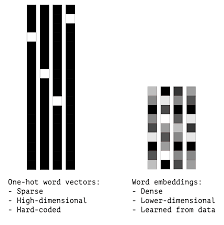

Embeddings are more useful then OHE when our problem involves a huge vocabulary. OHE needs vectors of length N to encode words belonging to a vocabulary of N tokens. On the other hand, Word Embedding uses a fixed length to encode a vocabulary of N tokens. It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1,024-dimensional when dealing with very large vocabularies. So, word embeddings pack more information into ar fewer dimensions.

Hopefully, we don't have to think a way to fill those M-dimentional dense vectors manually. Usually embeddings are obtained via two approaches:

1. Learn word embeddings joinly with the main task we care about. So in this case embeddings are an extra layer on our neural network that their weights are updated during backpropagation jointly with the task we are trying to solve, for example sentiment analysis. See [this tutorial](https://www.tensorflow.org/beta/tutorials/text/word_embeddings) to learn how to train word embeddings from scratch.

2. Load a matrix containing word embedding that were precomputed using a different machine-learning task. These are called pretrained *word embeddings*.

In this article we will focus on the second way of obtaining word embeddings. More precisely we are going to use GloVe embeddings [[4](#references)]. We are going to explore the embeddings learned from 6Billion tokens of text coming from Wikipedia.

> GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

### Playing with pretrained embeddings


In this section, we are going to use some vector operations and properties to see how embeddings behave and thus extract some useful takeaways. We are going to find the answer to the following sentences and more:

- What's up near a single embedding?
- What happens if we add two embeddings?

To start our journeym we first need to download the pretrained embeddings from the GloVe (Global Vectors for Word Representation) website. To get the `zip` file containing the embeddings we are going to use a shell *mini script*:

In [14]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip  #takes 4mins to download
#!unzip -o glove.6B.zip

We can see that inside the `glove.6B.zip` file are a bunch of `.txt` files:

- glove.6B.50d.txt        
- glove.6B.100d.txt       
- glove.6B.200d.txt       
- glove.6B.300d.txt 

The file naming convention is as follows:

```
tokens_used_for_training = '6B' # 6 bilions
length_of_embedding_vectors = '300'
file_name = f'glove.{tokens_used_for_training}.{length_of_embeddings}d.txt'
```

We will be using the `glove.6B.300d.txt` file, meaning that embeddings inside this files are 300-dimensional. 

GloVe embeddings come in txt files where each row contains a token and its embedding. A single row will look like as follows:

```
hello  0.341  -0.789  0.131 ...
```

We parse the file as a dict where the key is the word (or the token) and the value is the `numpy array` wrapping the embedding vector.

In [15]:
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time 
#takes roughly 1min
# Dict
# key -> the token (word)
# value -> word embedding
embeddings = {}
with open('glove.6B.300d.txt') as f:
    embeddings = {l.split()[0]: np.array(l.split()[1:]).astype('float') for l in f}

To understand better how we organize the embeddings we will print the first 5 word embeddings.

In [16]:
for i, (k, v) in enumerate(embeddings.items()):
    print('{} -> {}...'.format(k, v[:5]))
    if i == 5:
        break

the -> [ 0.04656    0.21318   -0.0074364 -0.45854   -0.035639 ]...
, -> [-0.25539  -0.25723   0.13169  -0.042688  0.21817 ]...
. -> [-0.12559   0.01363   0.10306  -0.10123   0.098128]...
of -> [-0.076947 -0.021211  0.21271  -0.72232  -0.13988 ]...
to -> [-0.25756  -0.057132 -0.6719   -0.38082  -0.36421 ]...
and -> [ 0.038466 -0.039792  0.082747 -0.38923  -0.21431 ]...


In [20]:
embeddings['ants'].shape

(300,)

#### The First experiment - Get closest embeddings

First, we define a function that will help us to get the top k similar embeddings to a word. The distance is computed via the euclidean distance

$ d(x, y) = (\sum_{k=1}^{n} | x_k - y_k |^2)^{1/2} $

> Note: Try to understand this function because it will be crucial with the following experiments.

In [21]:
def get_closest(x, top_k=3):
    """
    Get the closest embeddings calculating the euclidean distance

    Parameters
    ----------
    x: np.ndarray
    Vector containing an embedding
    top_k: int, optional
    Get the top k similar embeddings

    Returns
    -------
    dict
    Dict containing the top k similar embeddings to the given x
    """
    # Stack all embeddings in a single matrix. Note: the matrix dimention will be
    # V x D where V is the vocabulary size and D is the embedding dimension
    embedding_matrix = np.array(list(embeddings.values()))
    # Using broadcasting compute distance to each embedding in our vocabulary
    distances = x - embedding_matrix
    # Compute the magnitude of each distance
    distances = np.linalg.norm(distances, axis=1)
    # Sort distance and keep the smallest k
    min_idx = np.argsort(distances)[:top_k]
    return {list(embeddings)[i]: embedding_matrix[i] for i in min_idx}

Now we are going to retrieve the top 5 similar embeddings near to the token `dog`. If our intuition that word embeddings encode semantics we will get the embeddings corresponding to tokens like `pet`, `dogs`, etc.

In [22]:
similar_animal = get_closest(embeddings['dog'], top_k=5)
list(similar_animal)

['dog', 'dogs', 'cat', 'pet', 'puppy']

Wow! Our embeddings know how to represent a dog into a vector space. As we see, embeddings encode a lot of interesting features. For example, in this case, `dog` is very related to:
- `dogs` which it is its plural
- `cat` which is another `pet` 
- and also to `puppy` which is a little dog.

Fortunately, we can plot those embeddings in a 2D space to then better visualize them and understand how these semantics are encoded in a 2D space.

As you might notice, the embeddings that we are working with are 300-dimensional. So a question that instantly comes to our minds is: How can we plot a vector in a 300-dimensional space!?. The answer is simple, we can reduce a vector dimensionality using Principal Component Analysis (PCA). PCA allows us to project vectors to a lower-dimensional space without losing much information. To learn more about PCA refer to the [PCA sklearn User Guide](https://scikit-learn.org/stable/modules/decomposition.html#pca).

We are going to encapsulate the complexity (sklearn does the complex part 🙄) of the plot inside a function.

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition  import PCA

def to_2d(embeddings):
    # To reduce embedding dims without losing much information we use PCA
    pca = PCA(n_components=2, whiten=True)
    pca.fit(embeddings)
    return pca.transform(embeddings)


def annotated_scatter(points, names, color='blue'):
    x_coords = points[:, 0]
    y_coords = points[:, 1]

    plt.scatter(x_coords, y_coords, c=color)
    for label, x, y in zip(names, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

    plt.xlim(x_coords.min() - .5, x_coords.max() + .5)
    plt.ylim(y_coords.min() - .5, y_coords.max() + .5)
    
    
def plot_embeddings(embeddings, names, color='blue', show=True):
    X_train = np.array([embeddings[k] for k in names])

    embeddings_2d = to_2d(X_train)

    annotated_scatter(embeddings_2d, names, color)
    plt.grid()

    if show:
        plt.show()

Now we will plot the embeddings similar to `dog` and embeddings similar to `computer`. This way we will be able to see two clusters of embeddings, one cluster for tokens related to pets and another cluster for tokens related to techology. 

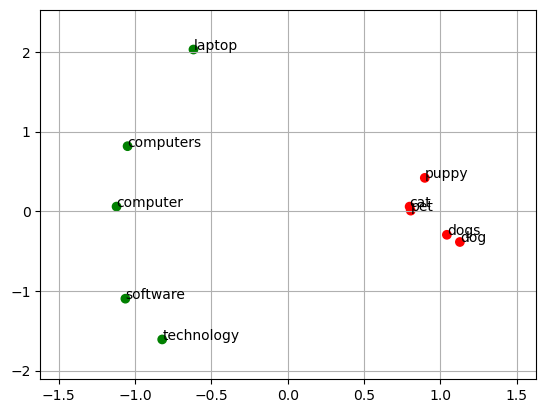

In [27]:
near_dog = list(similar_animal)
near_computer = list(get_closest(embeddings['computer'], top_k=5))

plot_embeddings(embeddings, 
                near_dog + near_computer, 
                color=['red'] * len(near_dog) + ['green'] * len(near_computer));

Interesting, isn't it? Now, we have seen that embeddings encode word semantics and therfore we can use it to get words with similar meanings. That is important for deep learning tasks such as sentiment analysis, document classification, topic extraction, etc. 

Interestingly, when we train word embeddings from scratch for a sentiment analysis task, we end up learning embeddings that their representation is composed of two clusters.
1. one cluster for positive tokens
2. and another for negative tokens.

#### The second Experiment - Adding two embeddings

Before adding 2 embeddings and observe interesting properties, we first need to identify the linear substructures. We can think of linear substructures as relationships that exist between words. Some linear substructures include:

- Man ~ Woman -> Linear Substructure: Sex
- King ~ Queen -> Linear Substructure: Sex
- Dog ~ Canine -> Linear Substructure: Specie
- Cat ~ Feline -> Linear Substructure: Specie

Now, we are going to define a new function to plot pairs of linear substructures.

In [28]:
from collections import namedtuple
import matplotlib.lines as mlines
from matplotlib import cm

LinearSubs = namedtuple('LinearSubs', 
                        ('word_pair', 'name'))

def plot_linear_substructures(linear_subs):
    embeddings_matrix = [embeddings[p] for ls in linear_subs for p in ls.word_pair]
    embeddings_matrix = np.array(embeddings_matrix)

    pair_names = [p for ls in linear_subs for p in ls.word_pair]
    ls_names = [ls.name for ls in linear_subs]
    embeddings_2d = to_2d(embeddings_matrix)

    annotated_scatter(embeddings_2d, 
                    pair_names, 
                    cm.Set1.colors[:len(embeddings_2d)])
  
    for i in range(0, len(embeddings_2d), 2):
        p1 = embeddings_2d[i]
        p2 = embeddings_2d[i + 1]
        # Center of the linear substructure
        center = [(p1[i] + p2[i]) / 2 + .04 for i in range(2)]

        plt.plot(*zip(p1, p2), '--')
        plt.annotate(ls_names[i // 2], 
                     xy=center, 
                     xytext=(0, 0), textcoords='offset points')

In the following plot we can see three different interesting linear substructures:

1. Sex: We use this linear structure to convert from male to female
2. Family: Given an animal species, such as cat, we can get its family using the species linear substructure
3. Product: Given a brand name like Samsung exists a linear relation to the kind of product that they manufacture.

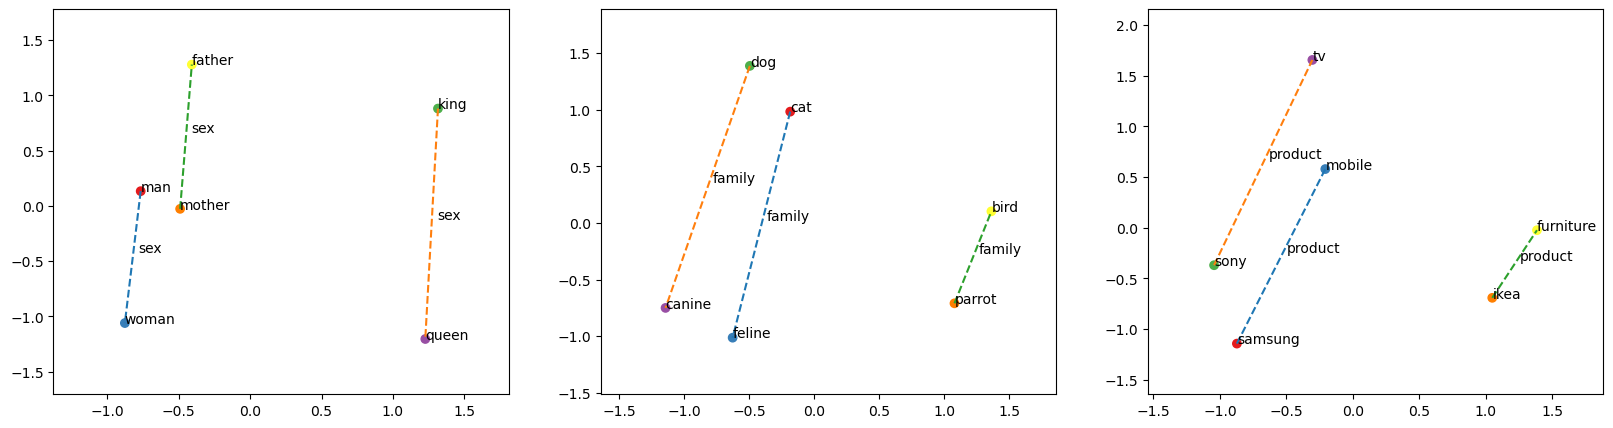

In [29]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plot_linear_substructures([LinearSubs(('man', 'woman'), 'sex'),
                           LinearSubs(('king', 'queen'), 'sex'),
                           LinearSubs(('mother', 'father'), 'sex')])

plt.subplot(132)
plot_linear_substructures([LinearSubs(('cat', 'feline'), 'family'),
                           LinearSubs(('dog', 'canine'), 'family'),
                           LinearSubs(('parrot', 'bird'), 'family')])

plt.subplot(133)
plot_linear_substructures([LinearSubs(('samsung', 'mobile'), 'product'),
                           LinearSubs(('sony', 'tv'), 'product'),
                           LinearSubs(('ikea', 'furniture'), 'product')])

Once, we have identified the linear substructures, we can use them to "approximate" other embeddings. For example:

- If we add the linear substructure `sex` to the word "son", then we will find an embedding that is close to `daughter` representation.

- The same would happen if we add the linear substructure `family` to an animal species.

See the below execution to corroborate this theory.

In [30]:
def get_linear_subs_vect(ls):
    return embeddings[ls.word_pair[1]] - embeddings[ls.word_pair[0]]

sex_ls = get_linear_subs_vect(LinearSubs(('man', 'woman'), 'sex'))
specie_ls = get_linear_subs_vect(LinearSubs(('canine', 'dog'), 'family'))

print('"Son" + male to female =', list(get_closest(embeddings['son'] + sex_ls, top_k=1)))
print('"Salmon" 🐟 + animal to specie =', list(get_closest(embeddings['salmon'] + specie_ls, top_k=5)))

"Son" + male to female = ['daughter']
"Salmon" 🐟 + animal to specie = ['salmon', 'fish', 'trout', 'lamb', 'herring']


As expected it works 😊. Let see what we exactly did:

1. First, we retrieved the vector which represents the linear substructure. To do so, we subtract two embeddings which are related by a known linear substructure. For example, subtracting `man` embedding to `woman` embedding results in the male to female linear substructure vector.
2. Then, we add this vector to a random embedding. In our case, instead of a random embedding, we chose "Son" embedding because it has a straight forward female "version", therefore we know that the expected output should be "daughter".
3. Finally, we get the top k closest embeddings to the result of the addition and check if the linear substructure is still valid for the recently pciked embedding.

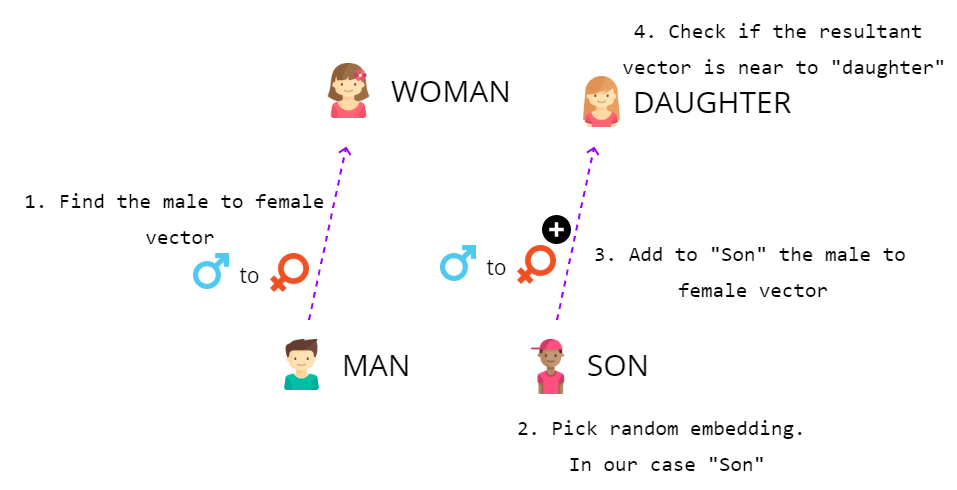</img>


## Conclusions

Important takeaways:

- Intelligent models cannot receive raw text as input, so we need to convert text to numbers. This process is called *vectorizing*.
- Even though, One Hot Encoding is memory inefficient in some small vocabularies may be the way to go.
- A more powerful technique to vectorize a vocabulary is word embedding. Word Embedding can encode semantics.
- Word Embeddings can be download from the internet (pretrained) or we can learn them from scratch jointly with our task.
- We can use the Word Embedding semantics to perform some operations on them.
  - Get k nearest neighbors
  - Approximate embeddings using observed linear substructures.

Thanks for reading my article. I am looking forward to seeing you again on my blog.


Addtional Resources:

1. **Using pre-trained word embeddings: Text classification on the Newsgroup20 dataset using pre-trained GloVe word embeddings.** https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/pretrained_word_embeddings.ipynb

## References
 <a id="references"></a>
- [1] Deep Learning with Python - François Chollet <a id="ref-1"></a>
- [2] BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding - https://arxiv.org/abs/1810.04805
- [3] RoBERTa: An optimized method for pretraining self-supervised NLP systems - https://arxiv.org/abs/1907.11692
- [4] GloVe: Global Vectors for Word Representation - https://nlp.stanford.edu/projects/glove/